# network.ipynb

Contains the implementation and experimentation with neural networks from scratch (only numpy)

## Design
##### Network(sizes, activations, cost)
- ex: `N = Network([10, 5, 7, 2], [relu, relu], cross_entropy_loss)`


In [1]:
import numpy as np

In [23]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp = np.exp(x)
    return exp / np.sum(exp, axis = 0)

def cross_entropy_loss(Y_pred, Y_true):
    return -np.sum(Y_true * np.log2(Y_pred)) #todo: test

def cross_entropy_loss_derivative(Y_pred, Y_true):
    return Y_pred - Y_true

d = {relu: relu_derivative, cross_entropy_loss: cross_entropy_loss_derivative}

In [33]:
class Network:
    def __init__(self, sizes, activations, cost):
        '''
        Initialize all parameters in the network.
        Weight matricies are initialized according to He et. al.
        Bias vectors are initialized to 0.
        '''
        self.W = [ np.random.randn(sizes[l + 1], sizes[l]) * np.sqrt(2 / sizes[l]) for l in range(len(sizes) - 1) ]
        self.b = [ np.zeros((size, 1)) for size in sizes[1:] ]
        self.g = activations + [softmax]
        self.cost = cost
        
    def dump(self):
        for i, W, b, g in zip(range(len(self.W)), self.W, self.b, self.g):
            print(f'Layer {i} W:{W.shape} b:{b.shape} g:{g}')
        
    def forward(self, X):
        '''
        Feeds X forward through the network.
        Returns (Z, A) lists of the unweighted and weighted activations in each layer.
        '''
        Z, A = [X], [X]
        for W, b, g in zip(self.W, self.b, self.g):
            Z.append(np.dot(W, A[-1]) + b)
            A.append(g(Z[-1]))
        return Z, A
    
    def backward(self, Z, A, Y):
        '''
        Computes derivatives for each parameter via backprop.
        Z, A as in forward()
        Y is one hot of true labels
        Returns (dW, db) lists of the gradients of each weight matrix and bias vector.
        '''
        dW, db = [], []
        dZ = cross_entropy_loss_derivative(A[-1], Y)
        m = Y.shape[1]
        for W, g, z, a in zip(self.W[::-1], self.g[-2::-1], Z[-2::-1], A[-2::-1]):
            dW.insert(0, (1 / m) * np.dot(dZ, a.T))
            db.insert(0, np.mean(dZ, axis = 1, keepdims = True))
            dZ = np.dot(W.T, dZ) * d[g](z)
        dW.insert(0, (1 / m) * np.dot(dZ, A[0].T))
        db.insert(0, np.mean(dZ, axis = 1, keepdims = True))
        return dW, db
    
    def fit(self, X, Y, alpha = 0.1, E = 100):
        '''
        Fits the network to the training data X, Y using gradient descent.
        '''
        for e in range(E):
            Z, A = self.forward(X)
            dW, db = self.backward(Z, A, Y)
            self.W = [ w - alpha * g for w, g in zip(self.W, dW) ]
            self.b = [ b - alpha * g for b, g in zip(self.b, db) ]
            self.progress_update(A[-1], Y, e)
            
    def progress_update(self, A, Y, e):
        cost = self.cost(A, Y)
        error_rate = self.error_rate(A, Y)
        print(f'epoch {e}: cost: {cost} error rate: {error_rate}')
        
    def error_rate(self, A, Y):
        labels = np.argmax(Y, axis = 0)
        predictions = np.argmax(A, axis = 0)
        return np.mean(labels != predictions)
    
    def predict(self, X):
        Z, A = self.forward(X)
        return np.argmax(A[-1], axis = 0)

In [27]:
N = Network([3, 50, 50, 50, 50, 2], [relu] * 4, cross_entropy_loss)
X = np.random.randn(3, 50)

I = np.random.randint(0, 2, size = 50)
Y = np.eye(2)[I].T
N.fit(X, Y, 0.01, 100)

epoch 0: cost: 58.69303228172716 error rate: 0.56
epoch 1: cost: 56.813883139902686 error rate: 0.54
epoch 2: cost: 55.227585319462804 error rate: 0.58
epoch 3: cost: 53.846895799154005 error rate: 0.52
epoch 4: cost: 52.637475442098776 error rate: 0.52
epoch 5: cost: 51.59483261040363 error rate: 0.5
epoch 6: cost: 50.64803465428657 error rate: 0.5
epoch 7: cost: 49.7999573761281 error rate: 0.5
epoch 8: cost: 49.03803473807088 error rate: 0.5
epoch 9: cost: 48.36242219073177 error rate: 0.46
epoch 10: cost: 47.72877814722399 error rate: 0.46
epoch 11: cost: 47.16898509095674 error rate: 0.42
epoch 12: cost: 46.680255454142355 error rate: 0.44
epoch 13: cost: 46.23688265777193 error rate: 0.42
epoch 14: cost: 45.83187813221342 error rate: 0.38
epoch 15: cost: 45.453443712989966 error rate: 0.36
epoch 16: cost: 45.10176472508154 error rate: 0.36
epoch 17: cost: 44.77134848795822 error rate: 0.32
epoch 18: cost: 44.463631467819205 error rate: 0.32
epoch 19: cost: 44.175202518409115 erro

In [9]:
from keras.datasets import mnist

(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = mnist.load_data()
print(X_train_orig.shape)
print(Y_train_orig.shape)
print(X_test_orig.shape)
print(Y_test_orig.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [29]:
X_train = X_train_orig.reshape(60000, -1).T / 255
X_test = X_test_orig.reshape(10000, -1).T / 255
Y_train = np.eye(10)[Y_train_orig].T
Y_test = np.eye(10)[Y_test_orig].T

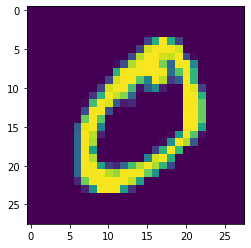

In [11]:
import matplotlib.pyplot as plt
plt.imshow(X_train[:, 1].reshape(28, 28))

In [34]:
N = Network([784, 64, 64, 10], [relu] * 2, cross_entropy_loss)
N.fit(X_train[:, :10], Y_train[:, :10], 0.01, 100)
predictions = N.predict(X_train)
print(predictions)
print(Y_train_orig)

epoch 0: cost: 34.3412489265195 error rate: 1.0
epoch 1: cost: 33.08105066554364 error rate: 0.9
epoch 2: cost: 31.97872233130015 error rate: 0.8
epoch 3: cost: 30.978150941988165 error rate: 0.7
epoch 4: cost: 30.068897756105372 error rate: 0.6
epoch 5: cost: 29.209816293334065 error rate: 0.6
epoch 6: cost: 28.397703036588492 error rate: 0.6
epoch 7: cost: 27.59948410099374 error rate: 0.6
epoch 8: cost: 26.863887514066565 error rate: 0.6
epoch 9: cost: 26.128254823943823 error rate: 0.5
epoch 10: cost: 25.411226166588428 error rate: 0.5
epoch 11: cost: 24.74021925869646 error rate: 0.3
epoch 12: cost: 24.087631192905025 error rate: 0.3
epoch 13: cost: 23.46627179165018 error rate: 0.2
epoch 14: cost: 22.854007689031143 error rate: 0.2
epoch 15: cost: 22.262725558855017 error rate: 0.2
epoch 16: cost: 21.677055455037998 error rate: 0.1
epoch 17: cost: 21.114615753902996 error rate: 0.1
epoch 18: cost: 20.58316385800431 error rate: 0.1
epoch 19: cost: 20.01883686720485 error rate: 0.1